Material in test but has less than 6 occurrences in train:
Unique materials in test with less than 6 occurrences in train:
name_part1
PCS                4
NiTiNbO            4
Fe2O3              4
CaSiO3             3
polysiloxane       3
Ni                 3
BaTiO3             3
Si                 2
fireclay           2
Zeo                2
Ag                 2
LSCF               1
theophylline       1
CaP                1
Ca3ZrSi2O9         1
stainless steel    1
CuO                1
PU                 1
AlN                1
Merwinite          1
Cr2O3              1
BT                 1
Name: count, dtype: int64


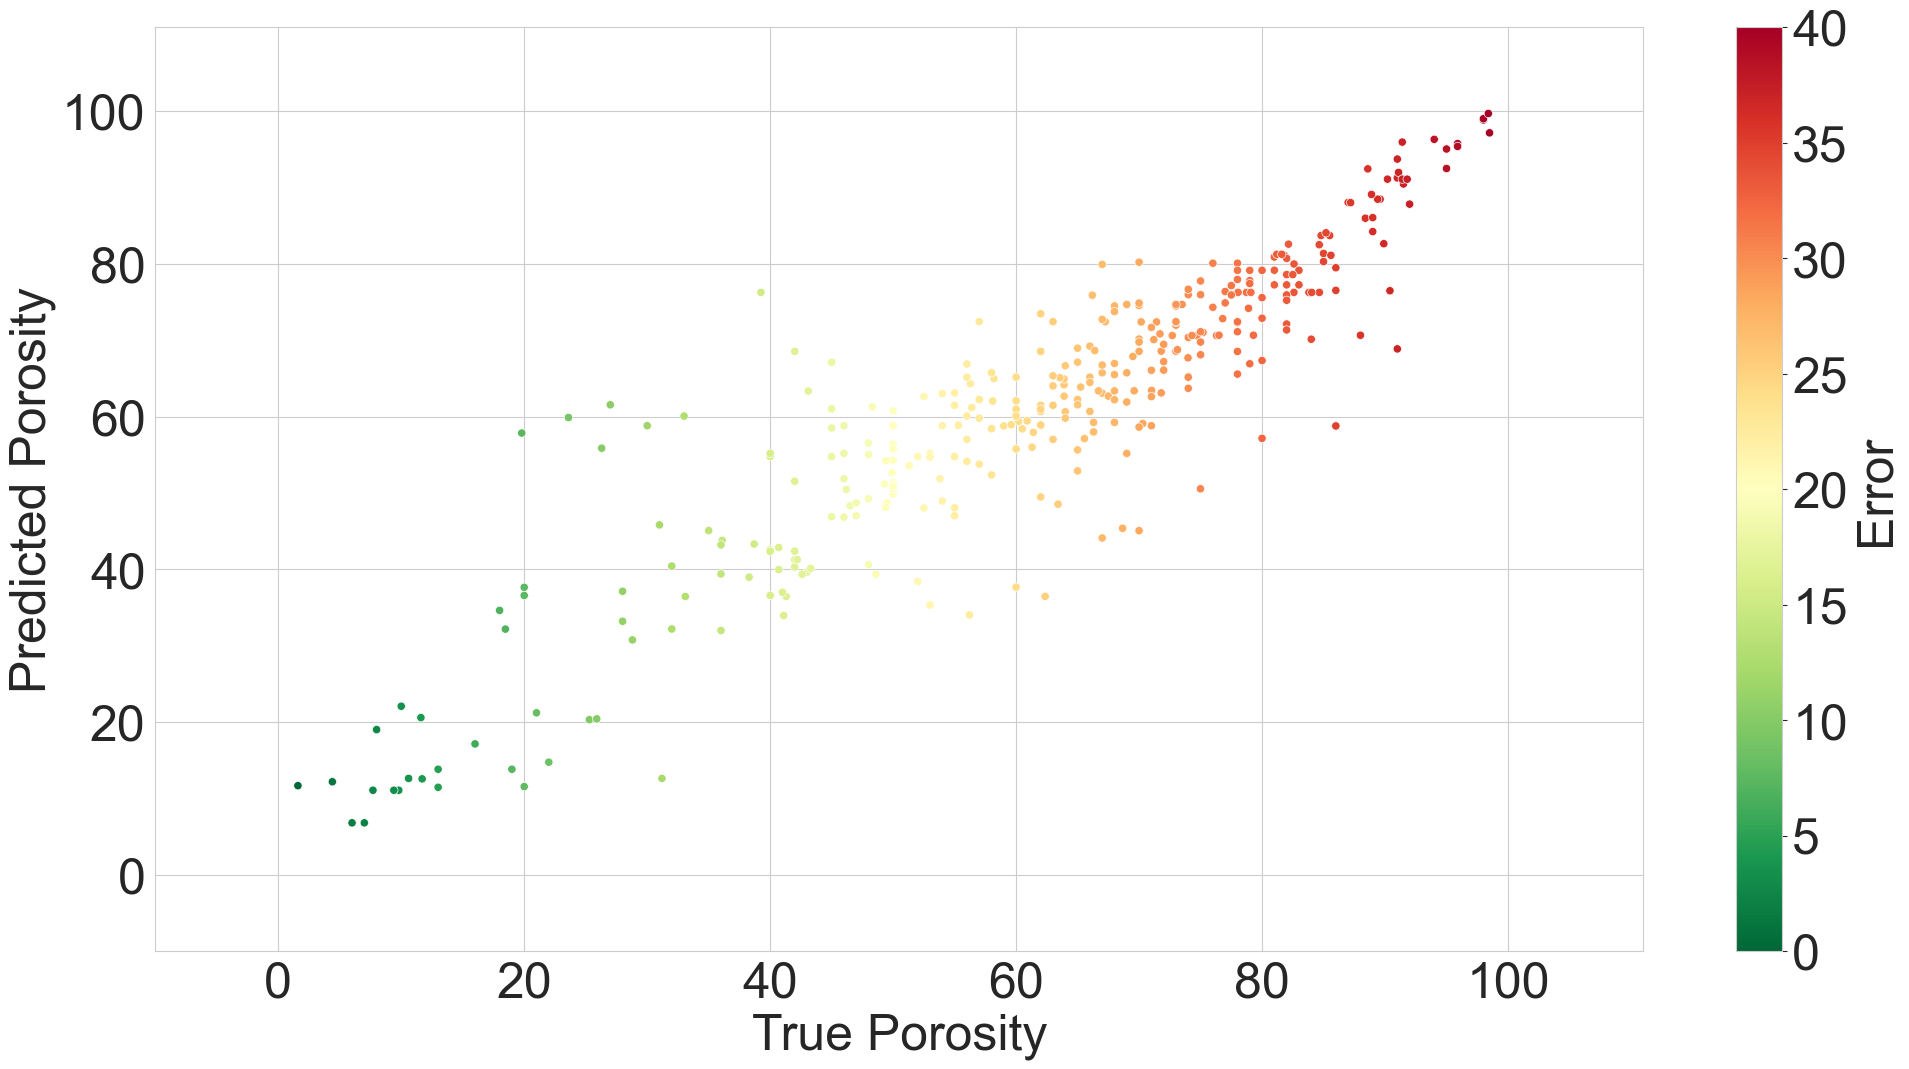

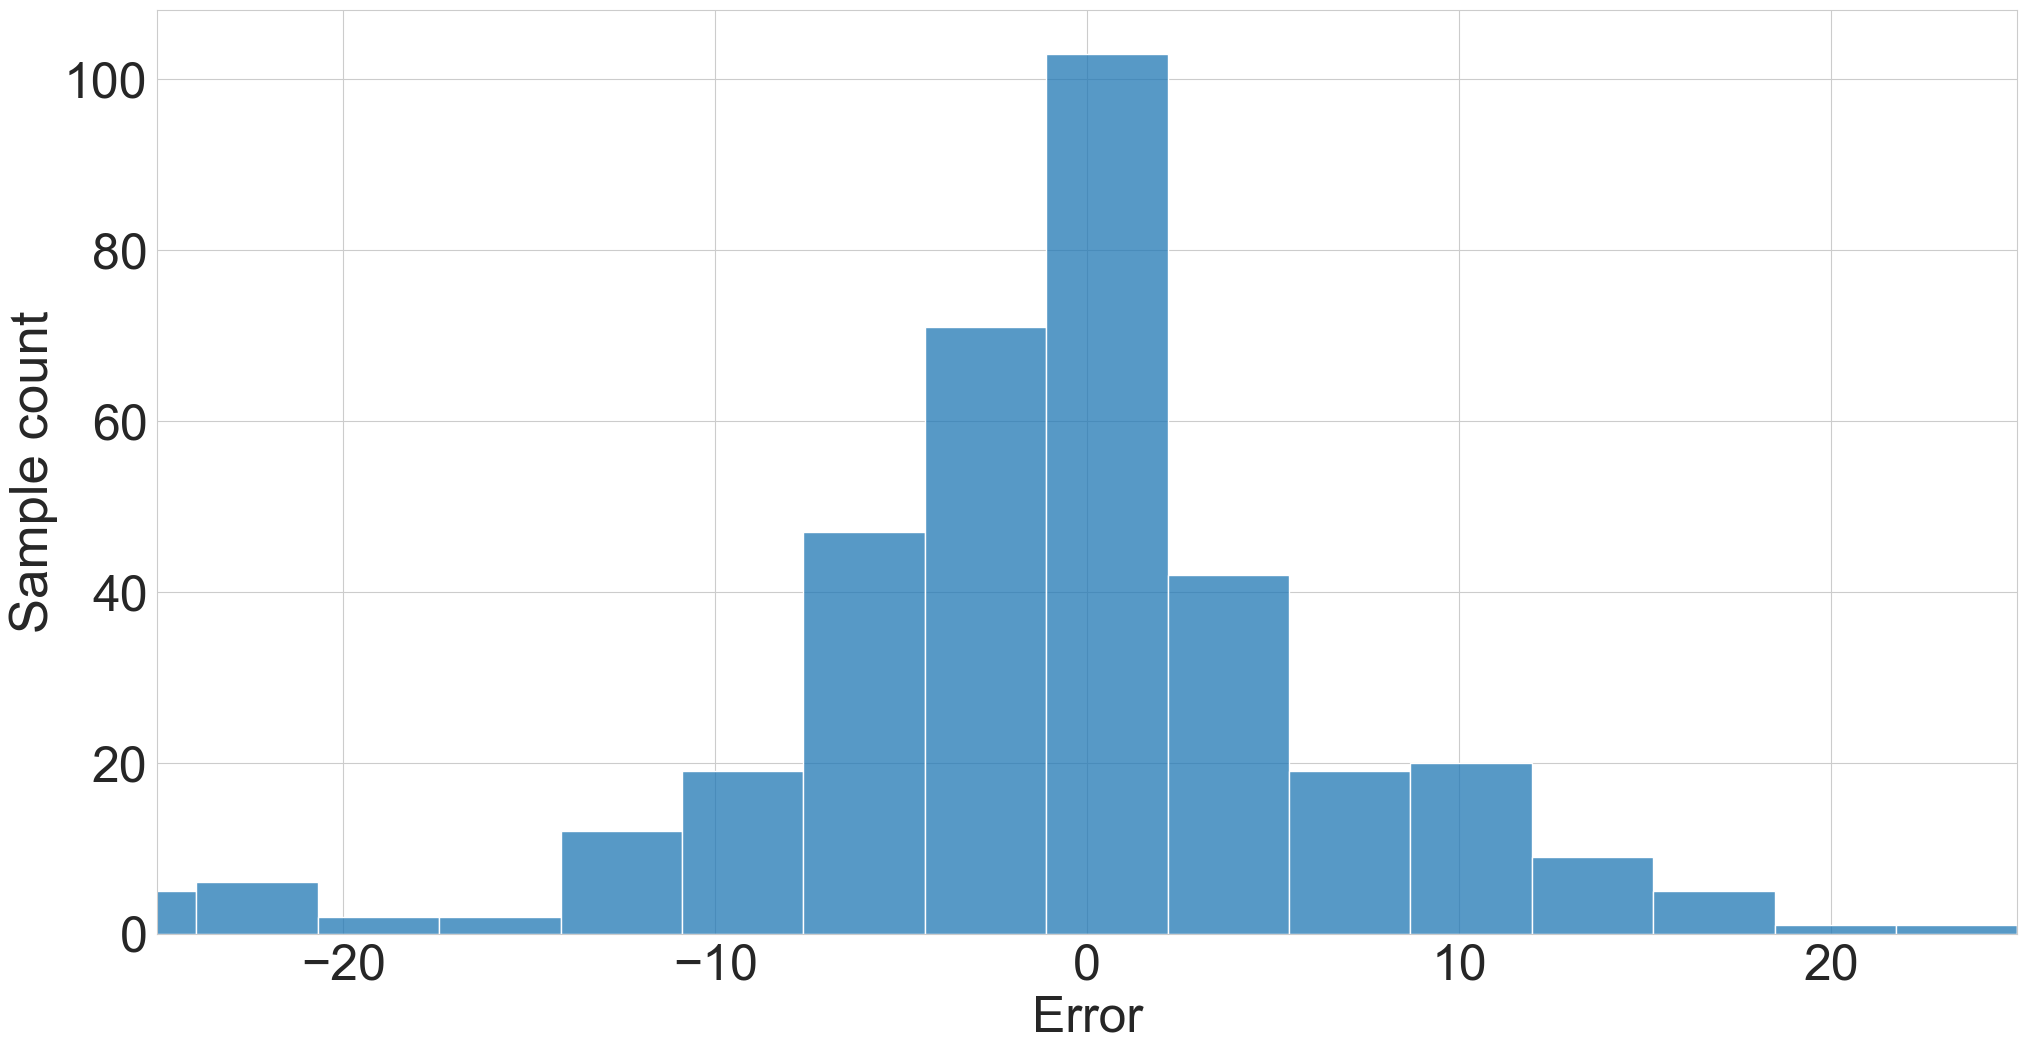

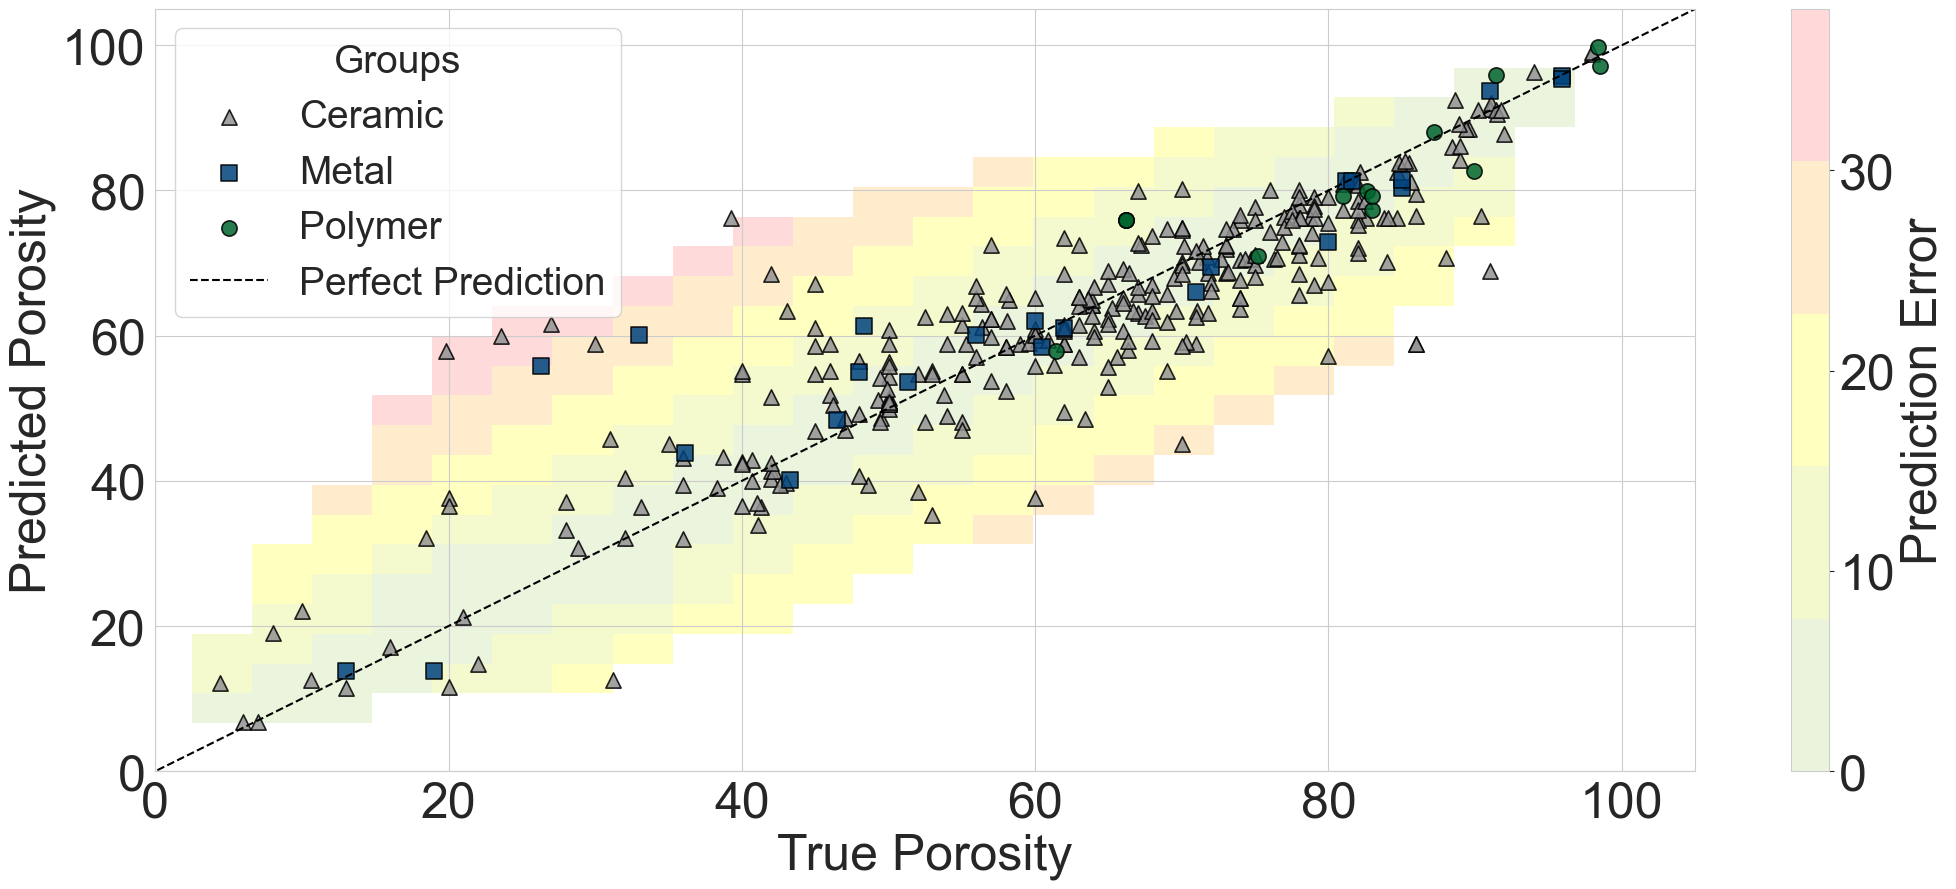

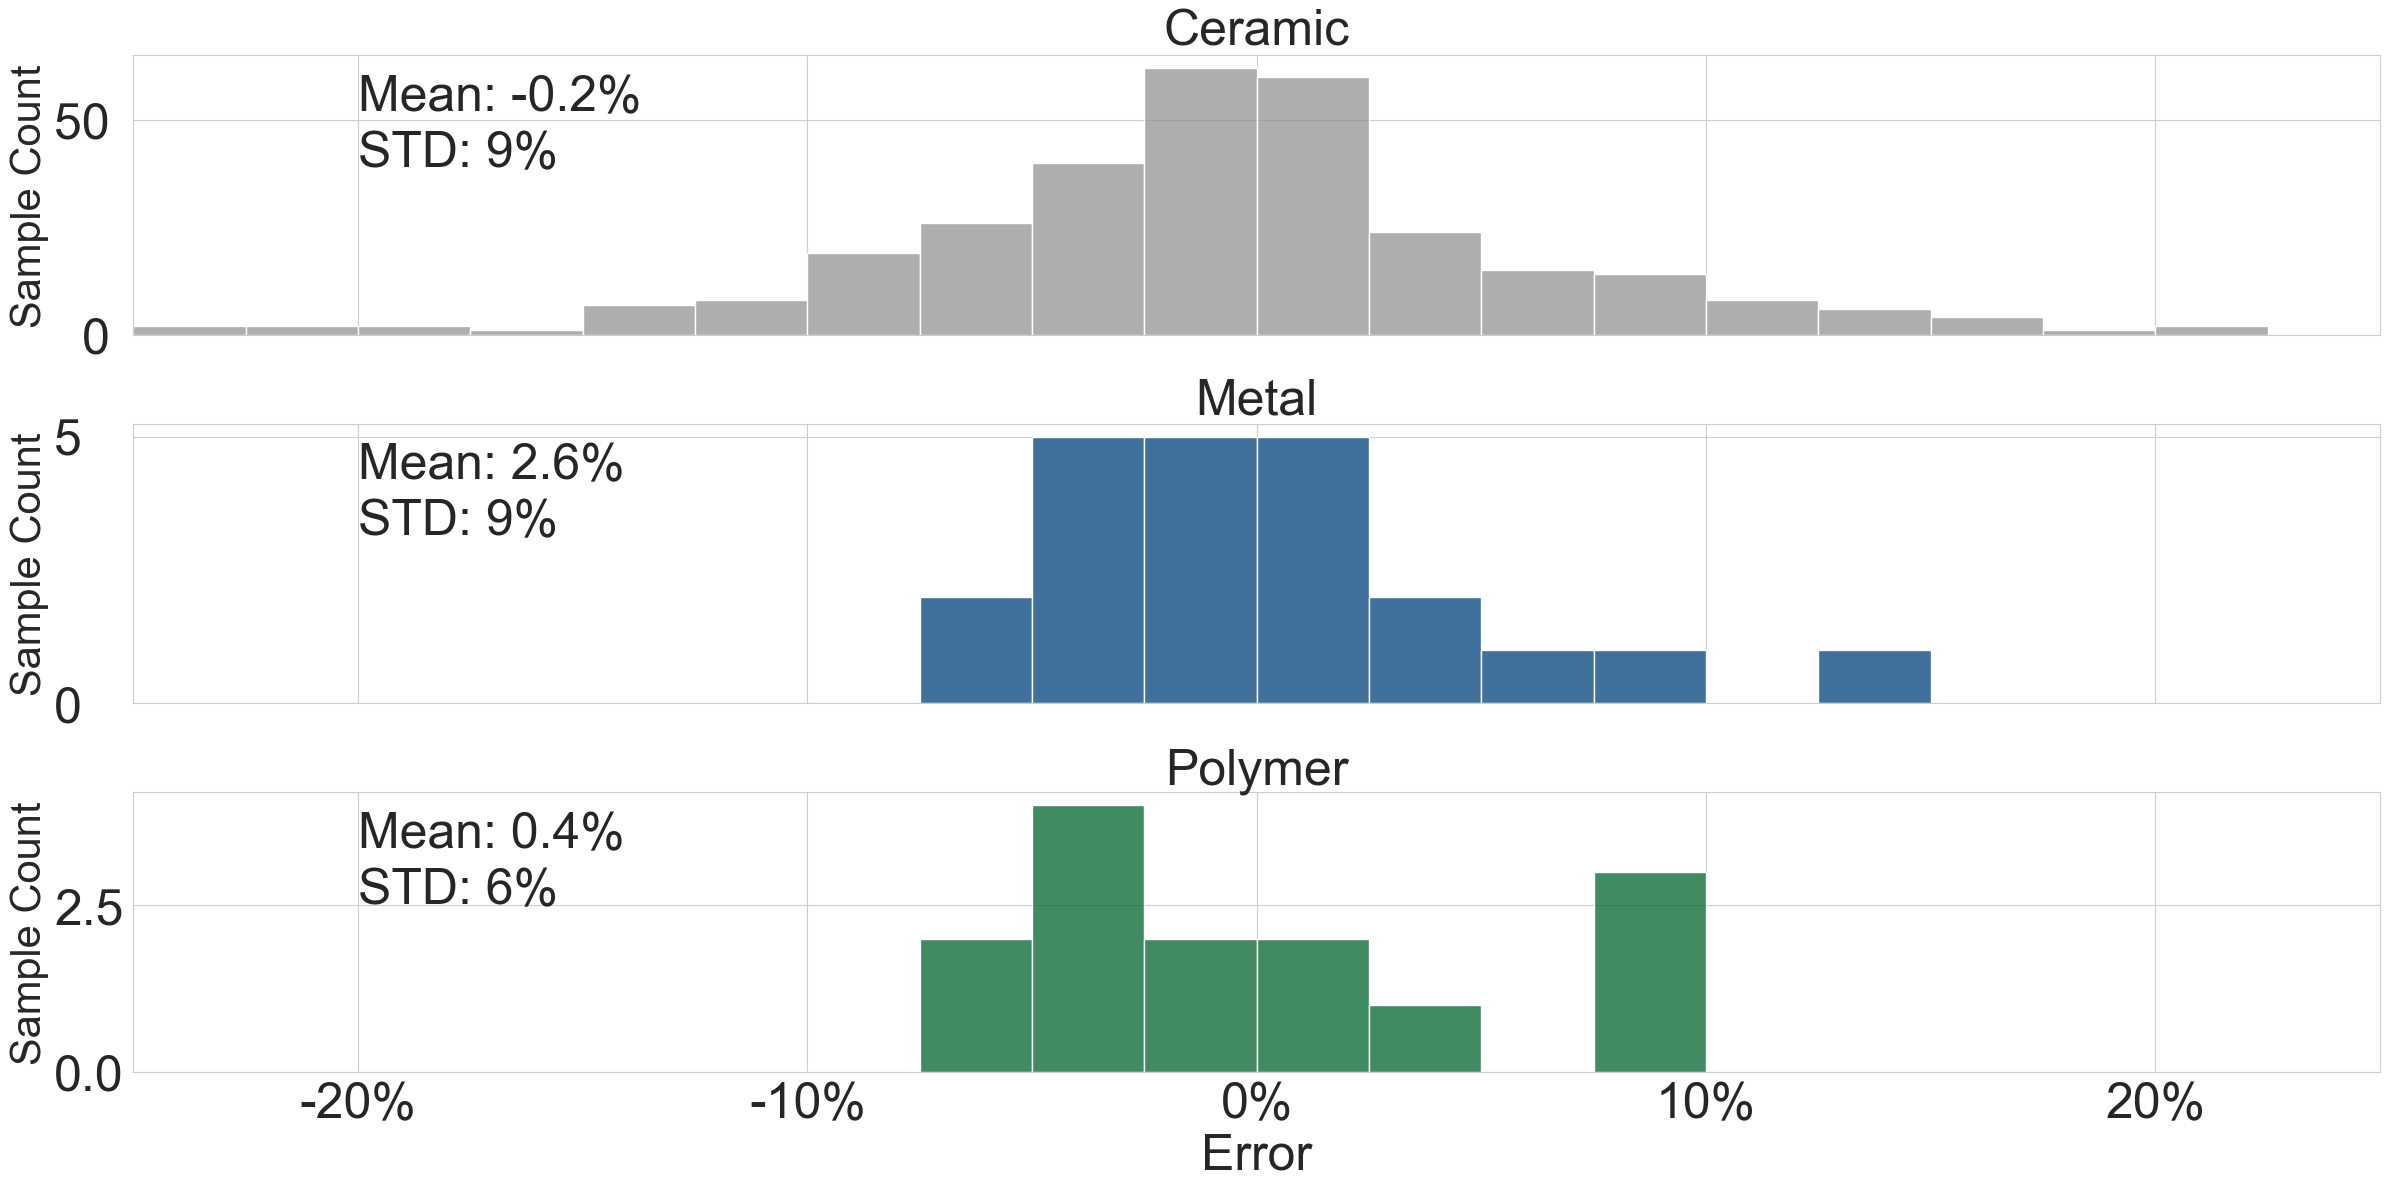

In [1]:
from typing import List
from helpers.custom_features import add_material_novelty_feature, add_bin_material_frequency
from data_parser import DataParser
import warnings
import glob
import os
from scipy.stats import kstest
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize, LinearSegmentedColormap
from scipy.interpolate import griddata
import matplotlib.ticker as ticker
from helpers.metrics_utils import get_pipeline_metrics

# glovan environemnt features : used for analysis after train
FEATURE_SET = "reduced_feats"
FEATURES_TO_ANALYZE = ["material_group", "name_part1", "name_fluid1", "name_part1_novel_in_test", "name_part1_freq_bin", "year"]
COLUMNS_NOT_NULL = ["name_part1", "name_fluid1", "vf_total", "material_group"]
# Suppress warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)  # Shows all columns
pd.set_option('display.width', 1000)      # Widens the display to prevent wrapping
palette = sns.color_palette("RdYlGn_r", as_cmap=True)  # 'RdYlGn_r' reverses the palette (green to red)
colors = ["#939393", "#00427d", "#00652e"]
dpi=200
images_dir = f'images/results/'

import pandas as pd


def plot_error_distribution_by_group(df, error: pd.Series, group_column, title=""):
    # Create a save directory for images
    save_dir = f'{images_dir}/{title}_error_by_group_{group_column}.png'

    # Create a figure with 3 subplots (1 column, 3 rows)
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 12), sharex=True)

    # Define group names and their corresponding colors
    if group_column == "name_fluid1":
        groups = ['water', 'TBA', 'camphene']
    else:
        groups = ['Ceramic', 'Metal', 'Polymer']

    # colors = ['blue', 'red', 'green']
    # colors =  ["#505050", "#56B4E9", "#D55E00"]

    # Define custom bin edges with a step of 0.01
    bins = np.arange(-25, 25, 2.5)  # Bins from -0.4 to 0.4 with step size of 0.01

    # Loop through the groups to plot error distribution for each group
    for i, group in enumerate(groups):
        # Filter the dataframe for the current group
        group_df = df[df[group_column] == group]

        # Get the error values for the current group
        group_error = error[group_df.index]  # Use the error values for the current group

        # Plot the histogram on the corresponding subplot
        sns.histplot(group_error, bins=bins, color=colors[i], ax=axes[i], kde=False)

        # Set labels and title for the subplot
        axes[i].set_xlabel("Error", fontsize=36)
        axes[i].set_ylabel("Sample Count", fontsize=30)
        axes[i].tick_params(labelsize=36)
        axes[i].set_title(f"{group}", fontsize=36)
        axes[i].set_xlim(-25, 25)  # Limit x-axis to match the range
        # Add percentage sign to x-axis ticks
        axes[i].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.0f}%'))
        # Ensure y-axis tick labels are formatted correctly
        if i == 0:
            axes[i].set_yticklabels([f"{int(tick)} " for tick in axes[i].get_yticks()])

        if i== 1:
            axes[i].set_yticklabels([f"{int(tick)}   " for tick in axes[i].get_yticks()])

        # Calculate mean and standard deviation for the current group
        mean_error = np.mean(group_error)
        std_error = np.std(group_error)

        # Add mean and std dev as text labels on the plot
        axes[i].text(0.1, 0.85, f'Mean: {mean_error:.1f}%', ha='left', va='center', transform=axes[i].transAxes,
                     fontsize=36)
        axes[i].text(0.1, 0.65, f'STD: {std_error:.0f}%', ha='left', va='center', transform=axes[i].transAxes,
                     fontsize=36)

    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.8)  # Increase vertical spacing
    plt.tick_params(labelsize=36)  # Set font size for tick labels
    # Tight layout to avoid overlap of titles and labels
    plt.tight_layout()
    # Save the plot to the specified directory
    os.makedirs(os.path.dirname(save_dir), exist_ok=True)
    plt.savefig(save_dir, bbox_inches='tight', dpi=300)
    # Show and save the plot
    plt.show()


def plot_prediction_performance_by_group(true_values, predicted_values, group_column):
    save_dir = f'{images_dir}/perf_by_group.png'

    # Create a dataframe for easier plotting
    df = pd.DataFrame({
        'True': true_values,
        'Predicted': predicted_values,
        'Group': group_column
    })

    # Compute absolute error
    error = np.abs(true_values - predicted_values)

    # Define colormap for heatmap
    n_bins = 5
    # cmap = LinearSegmentedColormap.from_list('green_yellow_red', ['darkgreen', 'green', 'yellowgreen', 'yellow', 'orange', 'red', 'darkred'], N=n_bins)
    cmap = LinearSegmentedColormap.from_list('green_yellow_red_transparent',
                                             ['#aed476', '#ffff00', '#ff6b6b'], N=n_bins)
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(21, 9))

    # Create grid for interpolation
    xi = np.linspace(-100, 105, 50)
    yi = np.linspace(-100, 105, 50)
    X, Y = np.meshgrid(xi, yi)
    Z = griddata((df['True'], df['Predicted']), error, (X, Y), method='cubic')

    # Normalize error for color mapping
    norm = Normalize(vmin=0, vmax=np.max(error))

    # Heatmap background
    im = ax.imshow(Z, extent=[-100, 105, -100, 105], origin='lower', cmap=cmap, norm=norm, alpha=0.25, aspect='auto')

    # Get top 3 groups
    top_groups = df['Group'].value_counts().nlargest(3).index.tolist()

    # Define unique markers for each group
    markers = ['^', 's', 'o']

    # Use seaborn palette for colors
    # colors = sns.color_palette("tab10", len(top_groups))  # Extract distinct colors
    # colors = ["#505050", "#56B4E9", "#D55E00"]  # Gray, Light Blue, Purple

    # Plot scatter points for each group
    for i, group in enumerate(top_groups):
        group_df = df[df['Group'] == group]
        ax.scatter(group_df['True'], group_df['Predicted'],
                   color=colors[i],  # Assign color from palette
                   edgecolor='black',
                   linewidths=1.2,
                   marker=markers[i],  # Assign unique marker
                   alpha=0.85,
                   label=group,
                   s=120)  # Marker size

    # Add perfect prediction line (y = x)
    ax.plot([-100, 105], [-100, 105], color='black', linestyle='--', label='Perfect Prediction')

    # Labels and title with fontsize 28
    ax.set_xlabel('True Porosity', fontsize=36)
    ax.set_ylabel('Predicted Porosity', fontsize=36)
    # ax.set_title('True vs Predicted Values by Group', fontsize=36)

    # Set axis limits
    ax.set_xlim(0, 105)
    ax.set_ylim(0, 105)

    # Set tick labels size
    ax.tick_params(labelsize=36)

    # Colorbar customization
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Prediction Error', fontsize=36)  # Colorbar title
    cbar.ax.tick_params(labelsize=36)  # Colorbar tick labels

    # Add legend and set font size
    ax.legend(title='Groups', title_fontsize=28, fontsize=28, loc='best')

    # Save & display plot
    plt.tight_layout()
    os.makedirs(os.path.dirname(save_dir), exist_ok=True)
    plt.savefig(save_dir, bbox_inches='tight', dpi=300)
    plt.show()

def plot_prediction_performance(true_y, prediction: pd.Series, error: pd.Series, title=""):
    save_path = f'{images_dir}/{title}_perf.png'
    # Red-focused colormap
    # Model performance plot
    fig, ax = plt.subplots(figsize=(24, 12))  # This ensures t he figure and Axes are linked
    sns.scatterplot(x=true_y, y=prediction, hue=error,
                         palette=palette)
    norm = plt.Normalize(0, 40)  # set min and max for color_bar
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])
    # Adding colorbar correctly
    cbar = ax.figure.colorbar(sm, ax=ax)  # link colorbar to the Axes object
    cbar.set_label("Error", fontsize=36)
    cbar.ax.tick_params(labelsize=36)  # Increase colorbar tick label size

    ax.set_xlabel("True Porosity", fontsize=36)
    ax.set_ylabel(f"Predicted Porosity", fontsize=36)
    ax.get_legend().remove()


    ax.set(ylim=(-10, 111))
    ax.set(xlim=(-10, 111))
    ax.tick_params(labelsize=36)
    # sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


def plot_error_distribution(df, error: pd.Series, title=""):
    save_dir = f'{images_dir}/{title}_error.png'
    fig, ax = plt.subplots(figsize=(24, 12)) # This ensures the figure and Axes are linked
    sns.histplot(data=df, x=error,  # hue="Group",
                      bins=20,
                      palette=sns.color_palette("hls", 3)
                      )
    ax.set_xlabel("Error", fontsize=36)
    ax.set_ylabel(f"Sample count", fontsize=38)
    ax.tick_params(labelsize=36)
    ax.set(xlim=(-25, 25))
    x_axis = [round(num, 2) for num in np.linspace(-25, 25, 7)]
    os.makedirs(os.path.dirname(save_dir), exist_ok=True)
    plt.savefig(save_dir, bbox_inches='tight', dpi=300)
    plt.show()


def ks_test_group(group_df, column, distribution='norm'):
    # Perform the one-sample K-S test
    statistic, p_value = kstest(group_df[column], distribution)
    return pd.Series({'ks_statistic': statistic, 'p_value': p_value})



def load_data(feature_set: str) -> (pd.DataFrame, pd.DataFrame, str):
    """
    Load train and test CSVs for a given feature set and scale the target.
    Returns: df_train, df_test, target_column_name
    """
    parser = DataParser()
    target = parser.target

    train_path = f"data/{feature_set}/train.csv"
    test_path = f"data/{feature_set}/test.csv"
    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)

    # scale targets (e.g., to percent)
    df_train[target] *= 100
    df_test[target] *= 100

    return df_train, df_test, target

def load_pipelines_from_dir(base_dir: str) -> List[str]:
    """
    Recursively locate all model pickle files under base_dir.
    """
    """Get model paths from selected_models"""
    parser = DataParser()
    pickle_pipeline_paths = glob.glob(os.path.join(base_dir, '**', 'model', '*.pickle'), recursive=True)

    """Load models"""
    selected_pipes = []
    for pipe_path in pickle_pipeline_paths:
        pipe = parser.load_pipeline(pipe_path)
        selected_pipes.append(pipe)
    return selected_pipes

# def load_pipelines(paths: List[str]) -> List:
#     """
#     Load pipeline objects given their pickle paths.
#     """
#     parser = DataParser()
#     return [parser.load_pipeline(p) for p in paths]


def filter_null_mask(df: pd.DataFrame, required_cols: List[str], any_of: List[str]) -> pd.DataFrame:
    """
    Returns rows where all required_cols are non-null, and at least one column in any_of is non-null.
    """
    mask_required = df[required_cols].notna().all(axis=1)
    mask_any = df[any_of].notna().any(axis=1)
    return df[mask_required & mask_any]


def add_predictions_and_errors(df_test: pd.DataFrame, pipelines: List, target_column: str) -> pd.DataFrame:
    """
    For each pipeline, compute predictions, absolute error, and MAE, and add them to df_test.

    Args:
        df_test (pd.DataFrame): The test dataset.
        pipelines (list): List of trained pipelines.
        target_column (str): Name of the target column.

    Returns:
        pd.DataFrame: df_test with new columns per model:
                      - {model}_prediction
                      - {model}_error
                      - {model}_mae
    """
    df_result = df_test.copy()
    for pipeline in pipelines:
        y_true = df_result[target_column]*100
        y_pred = pipeline.predict(df_result)*100

        df_result[f"{pipeline.name}_prediction"] = y_pred
        df_result[f"{pipeline.name}_error"] = y_pred - y_true
        df_result[f"{pipeline.name}_mae"] = np.abs(y_pred - y_true)
    return df_result


if __name__ == "__main__":
    # Configuration
    FEATURE_SET = "reduced_feats"
    FEATURES_TO_ANALYZE = ["material_group", "name_part1", "name_fluid1", "name_part1_novel_in_test", "name_part1_freq_bin", "year"]
    COLUMNS_NOT_NULL = ["name_part1", "name_fluid1", "vf_total", "material_group"]
    parser = DataParser()

    # Load data and models
    df_train, df_test, TARGET = load_data(FEATURE_SET)
    df_train, df_test =  add_material_novelty_feature(df_train, df_test, min_count=6)
    df_train, df_test = add_bin_material_frequency(df_train, df_test, feature='name_part1')
    pipelines = load_pipelines_from_dir(f"selected_models/{FEATURE_SET}")



    # # Get metric tables
    # metrics_dict = get_pipeline_metrics(pipelines, df_train, df_test, TARGET, FEATURES_TO_ANALYZE, COLUMNS_NOT_NULL)
    # print("metrics:", metrics_dict.keys())
    # for key in metrics_dict['group_metrics'].keys():
    #     print(key, 'topn')
    #     print(metrics_dict['group_metrics']['catb']['topn'])
    #     print(key, 'all')
    #     print(metrics_dict['group_metrics']['catb']['all'])
    #     print('-'*40)

    # Get predictions and errors in dataframe
    df_test = add_predictions_and_errors(df_test, pipelines, TARGET)
    df_train = add_predictions_and_errors(df_train, pipelines, TARGET)

    # --- Performance Plots ---
    selected_model = 'catb_onehot[selected]'
    prediction_col = f"{selected_model}_prediction"
    true_y = df_test[parser.target]
    pred_y = df_test[prediction_col]
    error = pred_y - true_y

    plot_prediction_performance(true_y, pred_y, error=df_test.get(f"{selected_model}_mae"), title=selected_model)
    plot_error_distribution(df_test, error)
    plot_prediction_performance_by_group(true_y, pred_y, df_test['material_group'])
    plot_error_distribution_by_group(df_test, error, 'material_group')





